In [1]:
import os
import dgl
import torch

os.environ['DGLBACKEND'] = "pytorch" 
import matplotlib as plt
import networkx as nx
import numpy as np
import scanpy as sc 
import sklearn as sk
import squidpy as sq

import graph

ANNDATA_DIR = 'annData'
DLPFC_ANNDATA_DIR = os.path.join(ANNDATA_DIR, '1.DLPFC')

In [2]:
test_sample_id = '151507'
sample = sc.read_h5ad(os.path.join(DLPFC_ANNDATA_DIR, "{}.h5ad".format(test_sample_id)))
sample

/home/edgar/miniconda3/envs/STGCNDBC/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'layer_guess'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'layer_guess_colors', 'spatial'
    obsm: 'spatial'

In [3]:
# Create a DGL graph object
g = graph.create_dgl_graph(sample)

In [4]:
subgraph = graph.create_random_dgl_subgraph(g, 200)

In [5]:
network = dgl.to_networkx(subgraph.cpu(), node_attrs=['x'], edge_attrs=['w'])
network = nx.DiGraph(network).to_undirected(reciprocal=True)
network

In [6]:
def weighted_layout(G, weight_attr='w', init_pos=None):
    if init_pos is None:
        pos = nx.spring_layout(G, pos=init_pos)
    else:
        pos = init_pos 
    src = []
    dst = []
    data = []
    for u, v, e in G.edges(data=True):
        src.append(u)
        dst.append(v)
        data.append(e[weight_attr].numpy().item())

    minw, maxw = min(data), max(data)
    rangew = maxw - minw

    for u, v, w in zip(src,dst,data):
        force = ((1 - w) - minw)/rangew - 0.5
        vector = pos[v] - pos[u]
        angle = np.arctan2(vector[1], vector[0])
        pos[v][0] += force*np.cos(angle)
        pos[v][1] += force*np.sin(angle)

    return pos

In [7]:
init_pos = subgraph.ndata['coords'].numpy()
print(subgraph)
init_pos = {i: init_pos[i] for i in range(len(init_pos))}
print(init_pos)


Graph(num_nodes=200, num_edges=39800,
      ndata_schemes={'x': Scheme(shape=(33538,), dtype=torch.float32), 'init_coords': Scheme(shape=(2,), dtype=torch.float32), 'coords': Scheme(shape=(2,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'd': Scheme(shape=(), dtype=torch.float32), 'w': Scheme(shape=(), dtype=torch.float32)})
{0: array([ 8828., 10555.], dtype=float32), 1: array([ 4079., 10422.], dtype=float32), 2: array([9866., 8762.], dtype=float32), 3: array([3270., 4430.], dtype=float32), 4: array([ 4422., 10782.], dtype=float32), 5: array([8229., 3487.], dtype=float32), 6: array([4497., 8746.], dtype=float32), 7: array([4022., 6229.], dtype=float32), 8: array([ 9655., 10318.], dtype=float32), 9: array([6303., 3241.], dtype=float32), 10: array([ 6966., 11628.], dtype=float32), 11: array([7247., 9712.], dtype=float32), 12: array([ 4148., 10302.], dtype=float32), 13: array([3189., 8622.], dtype=float

In [8]:
pos = weighted_layout(network, init_pos=init_pos)

In [9]:
# network.edges(data=True)

In [10]:
network_weights = [d['w'].numpy().item() for u,v,d in network.edges(data=True)]
minw, maxw = min(network_weights), max(network_weights)
rangew = maxw - minw
print(network_weights)
print(minw, maxw)
print((minw-minw)/rangew - 0.5, (maxw-minw)/rangew - 0.5)

[0.023787926882505417, 0.024425163865089417, 0.002937429118901491, 0.005075677298009396, 0.025205418467521667, 0.016660049557685852, 0.022937655448913574, 0.02429632656276226, 0.02472592145204544, 0.019223256036639214, 0.02239929884672165, 0.008205142803490162, 0.005635783541947603, 0.01360391452908516, 0.022212935611605644, 0.02514045126736164, 0.02367241121828556, 0.019714802503585815, 0.015251118689775467, 0.020344767719507217, 0.022437257692217827, 0.012068790383636951, 0.02309388481080532, 0.0068460069596767426, 0.020928194746375084, 0.019454335793852806, 0.009085504338145256, 0.005538001656532288, 0.01873239129781723, 0.024226460605859756, 0.01323146466165781, 0.02280215546488762, 0.018482306972146034, 0.021182533353567123, 0.009937839582562447, 0.021130280569195747, 0.024156656116247177, 0.01834261789917946, 0.02272883988916874, 0.016881084069609642, 0.02011682651937008, 0.024885257706046104, 0.018460044637322426, 0.015719396993517876, 0.020229436457157135, 0.013270399533212185,

In [11]:
# network_weights

In [12]:
# labels = {(u,v,): '{:.3}'.format(data['w'].numpy().item()) for u,v,data in network.edges(data=True)}
# labels

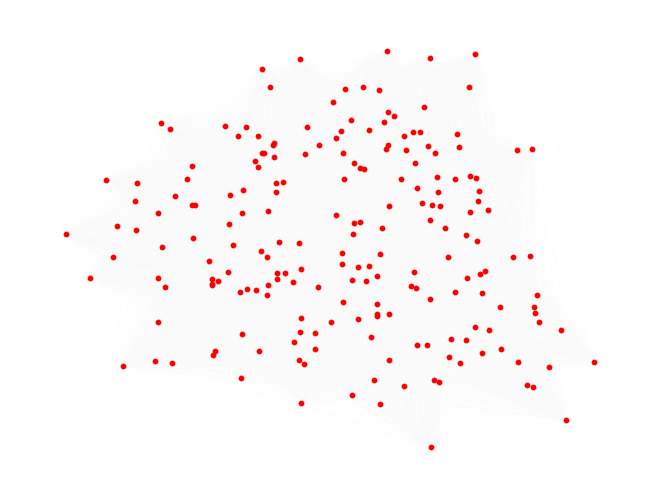

In [13]:
nx.draw(network, pos=subgraph.ndata['coords'].numpy(), node_size=10, width=0.3, node_color='red', edge_color=network_weights, edge_vmin=0, edge_vmax=1,  edge_cmap=plt.cm.gist_yarg)
# nx.draw_networkx_labels(network, pos=subgraph.ndata['coords'].numpy())
# nx.draw_networkx_edge_labels(network, pos=subgraph.ndata['coords'].numpy(), edge_labels=labels, label_pos=0.5)

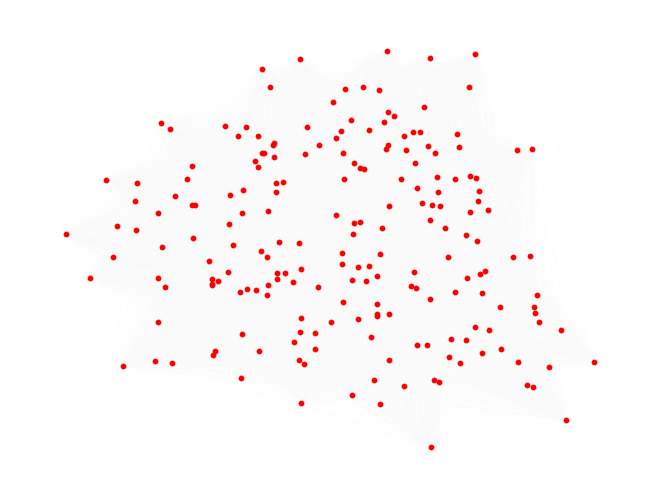

In [14]:
nx.draw(network, pos=pos, node_size=10, width=0.3, node_color='red', edge_color=network_weights, edge_vmin=0, edge_vmax=1,  edge_cmap=plt.cm.gist_yarg)
# nx.draw_networkx_labels(network, pos=subgraph.ndata['coords'].numpy())

In [15]:
spring_pos = nx.spring_layout(network, pos=init_pos,weight='w')

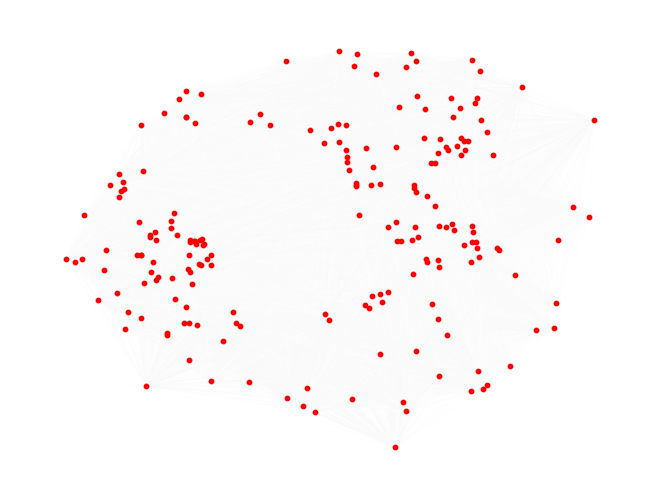

In [16]:
nx.draw(network, pos=spring_pos, node_size=10, width=0.3, node_color='red', edge_color=network_weights, edge_vmin=0, edge_vmax=1,  edge_cmap=plt.cm.gist_yarg)
# nx.draw_networkx_labels(network, pos=subgraph.ndata['coords'].numpy())

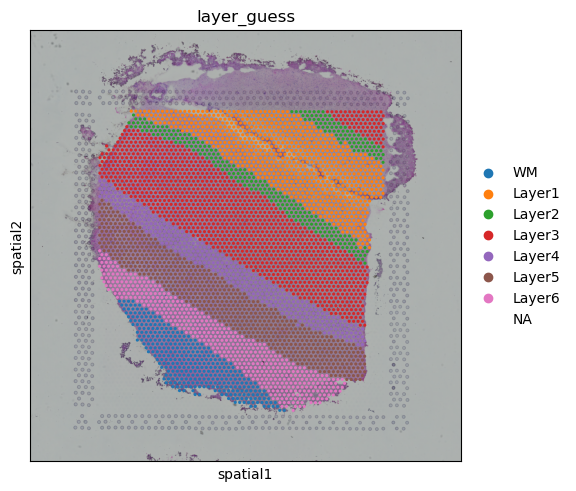

In [17]:
sq.pl.spatial_scatter(sample, color='layer_guess')